# Eighth working (crude) version of `lagaris01`

## Shrinking initialization range

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Specify hyperparameters.
nt = 11
H = 10
num_epochs = 2000
learning_rate = 0.01

# Create training data.
xt = tf.Variable(np.linspace(0, 1, nt).reshape((nt, 1)), dtype=tf.float32)

# Create the model.
tf.random.set_seed(0)
hidden_layer = tf.keras.layers.Dense(
    units=H, use_bias=True,
    activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1),
    bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
)
output_layer = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.linear,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
)
model = tf.keras.Sequential([hidden_layer, output_layer])

x = xt
losses = []

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print(datetime.datetime.now())
for i in range(num_epochs):
    # Compute the forward pass for each training point.
    with tf.GradientTape(persistent=True) as tape:
        N = model(xt)
        N = tf.reshape(N, (nt, 1))
        y = 1 + x*N
        dN_dx = tape.gradient(N, x)
        G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
        L = tf.reduce_sum(G**2)
        losses.append(L)

    # Compute the gradients.
    grad = tape.gradient(L, model.trainable_variables)

    # Update the parameters for this pass.
    opt.apply_gradients(zip(grad, model.trainable_variables))

print(L)
print(datetime.datetime.now())

2021-06-12 10:40:08.918109
tf.Tensor(0.005853972, shape=(), dtype=float32)
2021-06-12 10:40:18.839378


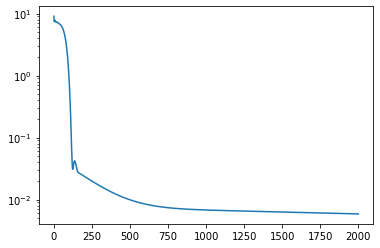

In [3]:
plt.semilogy(losses)
plt.show()

In [4]:
from math import exp

def Ya(x):
    return exp(-x**2/2)/(1 + x + x**3) + x**2

def dYa_dx(x):
    return 2*x - exp(-x**2/2)*(1 + x + 4*x**2 + x**4)/(1 + x + x**3)**2

In [5]:
nt = 101
xa = tf.Variable(np.linspace(0, 1, nt).reshape((nt, 1)), dtype=tf.float32)
ya = [Ya(x) for x in xa.numpy()[:, 0]]
dya_dx = [dYa_dx(x) for x in xa.numpy()[:, 0]]

with tf.GradientTape() as tape:
    N = model(xa)
dN_dx = tape.gradient(N, xa)
N = tf.reshape(N, (nt, 1))
dN_dx = tf.reshape(dN_dx, (nt, 1))
yt = 1 + xa*N
dyt_dx = xa*dN_dx + N

err = yt.numpy().reshape((nt)) - ya
derr = dyt_dx.numpy().reshape((nt)) - dya_dx

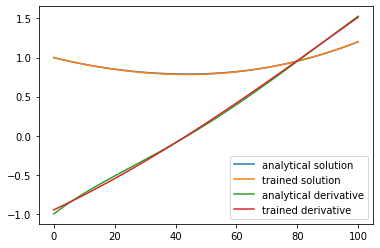

In [6]:
plt.plot(ya, label="analytical solution")
plt.plot(yt, label="trained solution")
plt.plot(dya_dx, label="analytical derivative")
plt.plot(dyt_dx, label="trained derivative")
plt.legend()
plt.show()

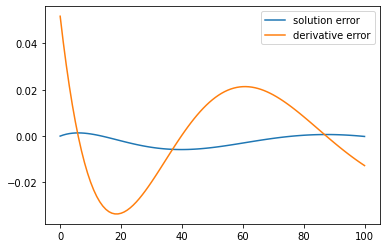

In [7]:
plt.plot(err, label="solution error")
plt.plot(derr, label = "derivative error")
plt.legend()
plt.show()